In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

timeseries_type,convective_fraction,longwave_radiation,potential_energy,potential_evaporation,pressure,shortwave_radiation,specific_humidity,temperature,total_precipitation,wind_u,wind_v,streamflow
count,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,352368.000000,167165.000000
mean,0.066877,287.914896,87.432447,0.156483,89598.797054,172.630518,0.006830,8.007243,0.146291,3.087925,1.355863,8.168125
std,0.219043,58.737226,252.992428,0.220480,598.187503,235.552655,0.003959,9.633644,0.579625,3.836947,3.725529,11.454635
min,0.000000,101.947035,0.000000,-0.464476,85749.703726,0.000000,0.000197,-32.897055,0.000000,-14.792259,-18.274209,0.044837
25%,0.000000,244.656019,0.000000,0.005510,89253.245160,0.000000,0.003284,0.724205,0.000000,0.555221,-1.097711,1.589146
50%,0.000000,294.409928,0.045483,0.048163,89685.856764,0.025756,0.006240,9.102345,0.000000,2.821515,1.214092,4.568795
75%,0.000000,334.018236,29.761213,0.249996,90017.879406,317.591111,0.010127,15.954080,0.003528,5.471104,3.432856,9.960540
max,1.000000,444.758946,4018.200726,0.969843,91680.141880,898.502935,0.019632,30.539339,20.788148,22.548462,22.113836,222.622330


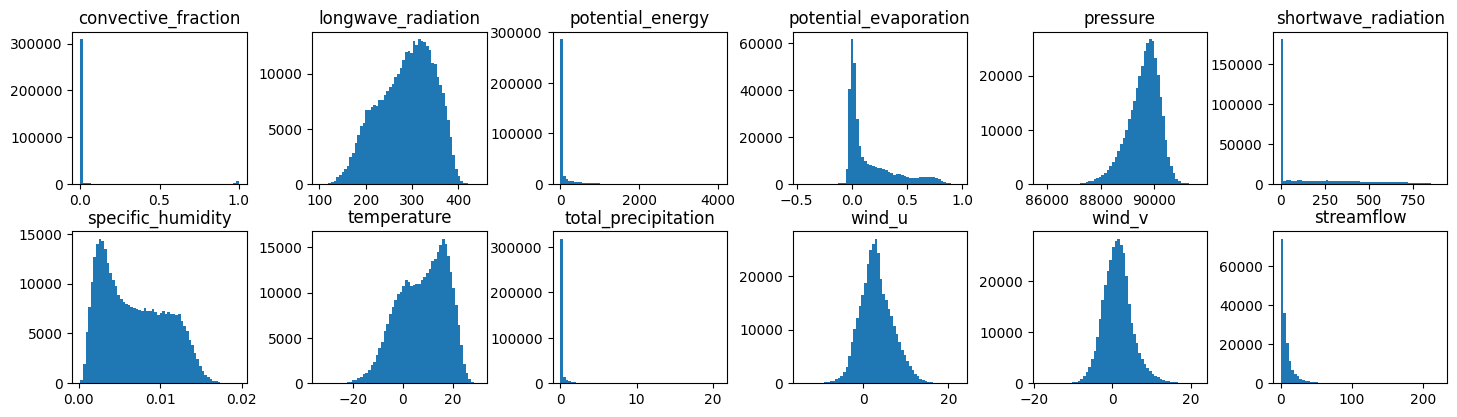

In [2]:
from hydronetwork.data.camels_us_hourly import load_timeseries, get_gauge_id
from hydronetwork.plot.matplotlib import hist

gauge_id = get_gauge_id(n=1)
timeseries = load_timeseries(gauge_id)
display(timeseries.describe())
fig, axis = hist(timeseries, ncols=6)

特征工程：
- convective_fraction: 极度偏态，多为0，添加特征if_convective
- longwave_radiation: 分布很均匀
- potential_energy: 极度偏态，取对数
- potential_evaporation: 极度偏态，取对数
- pressure: 分布很均匀
- shortwave_radiation: 极度偏态，取对数
- specific_humidity: 分布左偏但不严重
- temperature: 分布很均匀
- total_precipitation: 极度偏态，多为0，添加特征if_precipitation
- u_wind: 分布很均匀
- v_wind: 分布很均匀
- streamflow: 根据经验取对数

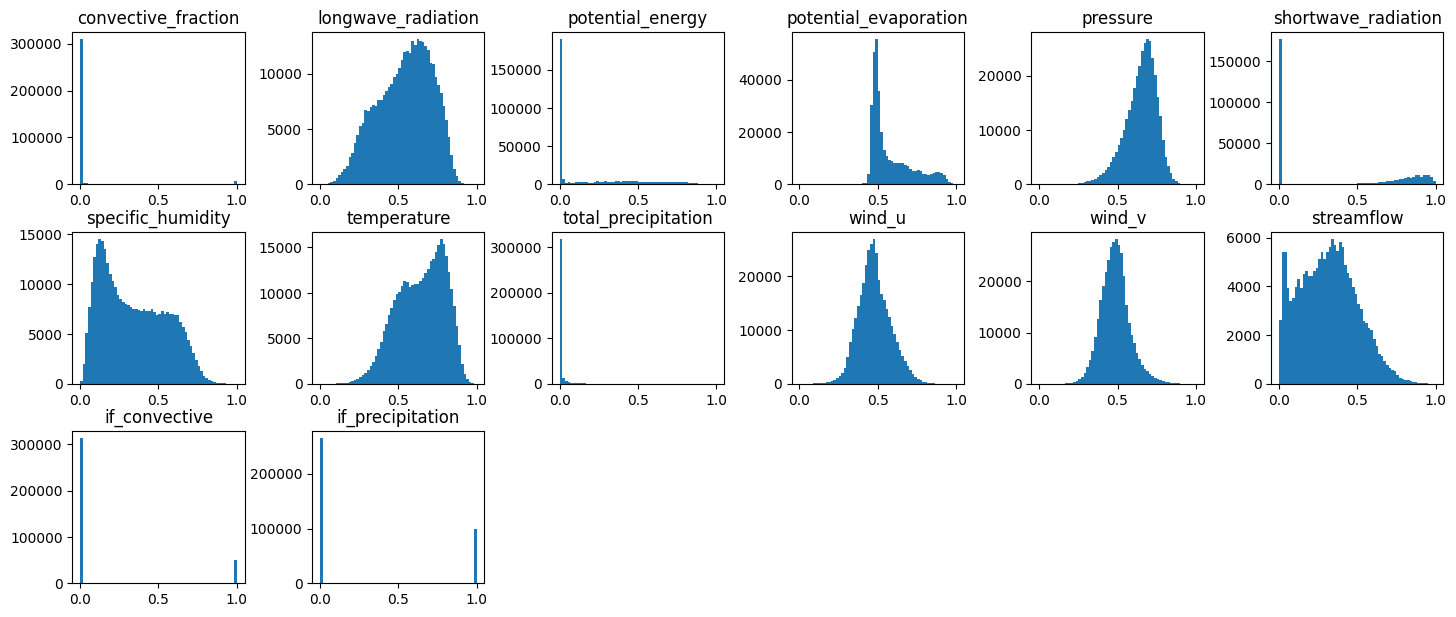

In [3]:
from hydronetwork.dataset import log_transform, log_inverse_transform, Normalizer
timeseries['if_convective'] = timeseries['convective_fraction'] > 0
timeseries['potential_energy'] = log_transform(timeseries['potential_energy'])
timeseries['potential_evaporation'] = log_transform(timeseries['potential_evaporation'])
timeseries['shortwave_radiation'] = log_transform(timeseries['shortwave_radiation'])
timeseries['if_precipitation'] = timeseries['total_precipitation'] > 0
timeseries['streamflow'] = log_transform(timeseries['streamflow'])
normalizer = Normalizer()
timeseries = timeseries.astype('float32')
timeseries = normalizer.normalize(timeseries)
fig, axis = hist(timeseries, ncols=6)

In [4]:
timeseries.columns

Index(['convective_fraction', 'longwave_radiation', 'potential_energy',
       'potential_evaporation', 'pressure', 'shortwave_radiation',
       'specific_humidity', 'temperature', 'total_precipitation', 'wind_u',
       'wind_v', 'streamflow', 'if_convective', 'if_precipitation'],
      dtype='object', name='timeseries_type')

In [5]:
from hydronetwork.dataset import split_timeseries, get_dataset

train_timeseries, test_timeseries = split_timeseries(data=timeseries, split_list=[0.6, 0.4])
args_dataset = args_get_dataset = {"lookback": 120,
                                   "horizon": 7,
                                   "features_bidirectional": ['convective_fraction', 'longwave_radiation',
                                                              'potential_energy', 'potential_evaporation', 'pressure',
                                                              'shortwave_radiation', 'specific_humidity', 'temperature',
                                                              'total_precipitation', 'wind_u', 'wind_v', 'streamflow',
                                                              'if_convective', 'if_precipitation'],
                                   # "features_lookback": "streamflow",
                                   "target": "streamflow",
                                   "use_multiprocessing": True,
                                   "batch_size": 512,
                                   }
train_dataset = get_dataset(train_timeseries, **args_dataset)
test_dataset = get_dataset(test_timeseries, **args_dataset)

In [8]:
from hydronetwork.model import encoder_decoder_lstm
from hydronetwork.train import WarmupExponentialDecay, callback_for_features_selection
from hydronetwork.evaluate.metric import nse  #为了方便优化器最小化，这里的nse公式是1-nse

model = encoder_decoder_lstm(horizon=args_get_dataset["horizon"],
                             lookback=args_get_dataset["lookback"],
                             encoder_hidden_units=256,
                             decoder_hidden_units=256,
                             features_type=["bidirectional"],
                             )
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=WarmupExponentialDecay(len(train_dataset))), loss=nse)
              

In [ ]:
model.fit(train_dataset,
          epochs=200,
          shuffle=True,
          validation_data=test_dataset,
          callbacks=callback_for_features_selection(),
          )

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 584ms/step - loss: 20.8464 - val_loss: 12.7482
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 601ms/step - loss: 18.5034 - val_loss: 11.7221
Epoch 3/200
26/75 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - loss: 7.9848

In [ ]:
from hydronetwork.evaluate import predict